<a href="https://colab.research.google.com/github/ClaudeCoulombe/VIARENA/blob/master/Labos/Lab-Identification_Arbres/Id_arbre-reseau_convolutif-transfert_amplification-colab.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Rappel - Fonctionnement d'un carnet web iPython

* Pour exécuter le code contenu dans une cellule d'un carnet iPython, cliquez dans la cellule et faites (⇧↵, shift-enter) 
* Le code d'un carnet iPython s'exécute séquentiellement de haut en bas de la page. Souvent, l'importation d'une bibliothèque Python ou l'initialisation d'une variable est préalable à l'exécution d'une cellule située plus bas. Il est donc recommandé d'exécuter les cellules en séquence. Enfin, méfiez-vous des retours en arrière qui peuvent réinitialiser certaines variables.

# Identification d'arbres à partir de leur écorce
## Réseau convolutif, apprentissage par transfert et amplification des données

##### Copyright 2019 The TensorFlow Authors.

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Apprentissage par transfert & amplification des données

## Fixer le hasard pour la reproductibilité

La mise au point de réseaux de neurones implique certains processus aléatoires. Afin de pouvoir reproduire et comparer vos résultats d'expérience, vous fixez temporairement l'état aléatoire grâce à un germe aléatoire unique.

Pendant la mise au point, vous fixez temporairement l'état aléatoire pour la reproductibilité mais vous répétez l'expérience avec différents germes ou états aléatoires et prenez la moyenne des résultats.
<br/>
**Note** : Pour un système en production, vous ravivez simplement l'état  purement aléatoire avec l'instruction `GERME_ALEATOIRE = None`

In [3]:
import os

# Définir un germe aléatoire
GERME_ALEATOIRE = 1

# Définir un état aléatoire pour Python
os.environ['PYTHONHASHSEED'] = str(GERME_ALEATOIRE)

# Définir un état aléatoire pour Python random
import random
random.seed(GERME_ALEATOIRE)

# Définir un état aléatoire pour NumPy
import numpy as np
np.random.seed(GERME_ALEATOIRE)

# Définir un état aléatoire pour TensorFlow
import tensorflow as tf
tf.random.set_seed(GERME_ALEATOIRE)

# Retrait du comportement déterministe
# à cause de keras.layers.RandomContrast(...)
# dont il n'existe pas de version déterministe
# os.environ['TF_DETERMINISTIC_OPS'] = '1'
# os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

print("Germe aléatoire fixé")

Germe aléatoire fixé


## Acquisition des donnés

In [4]:
import os

In [5]:
# Note that we did not use Acer platanoides (2), Pinus rigida (15) and Populus grandidentata (18)
# since we did not collect enough images in these categories to obtain meaningful results.
data_ecorces = {
    'SAB': 1,  
#    'ERB': 2,  # Pas assez de spécimens - seulement 1
    'ERR': 3, 
    'ERS': 4, 
    'BOJ': 5, 
    'BOP': 6,
    'HEG': 7,  
    'FRA': 8, 
    'MEL': 9,  
    'OSV': 10, 
    'EPO': 11,
    'EPB': 12,
    'EPN': 13,
    'EPR': 14,
#    'PID': 15, # Pas assez de spécimens - seulement 4
    'PIR': 16, 
    'PIB': 17, 
#    'PEG': 18, # Pas assez de spécimens - seulement 3
    'PET': 19, 
    'CHR': 20,
    'THO': 21, 
    'PRU': 22, 
    'ORA': 23  
}

noms_arbres = {
            1: '\emph{Abies balsamea} - Sapin Baumier - Balsam fir',
            2: '\emph{Acer platanoides} - Érable de Norvège - Norway maple',
            3: '\emph{Acer rubrum} - Érable rouge - Red maple',
            4: '\emph{Acer saccharum} - Érable à sucre - Sugar maple',
            5: '\emph{Betula alleghaniensis} - Bouleau jaune - Yellow birch',
            6: '\emph{Betula papyrifera} - Bouleau à papier - White birch',
            7: '\emph{Fagus grandifolia} - Hêtre à grandes feuilles - American beech',
            8: "\emph{Fraxinus americana} - Frêne d'Amérique - White ash",
            9: '\emph{Larix laricina} - Mélèze - Tamarack',
            10: '\emph{Ostrya virginiana} - Ostryer de Virginie - American hophornbeam',
            11: '\emph{Picea abies} - Épinette de Norvège - Norway spruce',
            12: '\emph{Picea glauca} - Épinette blanche - White spruce',
            13: '\emph{Picea mariana} - Épinette noire - Black spruce',
            14: '\emph{Picea rubens} - Épinette rouge - Red spruce',
            15: '\emph{Pinus rigida} - Pin rigide - Pitch pine',
            16: '\emph{Pinus resinosa} - Pin rouge - Red pine',
            17: '\emph{Pinus strobus} - Pin blanc - Eastern white pine',
            18: '\emph{Populus grandidentata} - Peuplier à grandes dents - Big-tooth aspen',
            19: '\emph{Populus tremuloides} - Peuplier faux tremble - Quaking aspen',
            20: '\emph{Quercus rubra} - Chêne rouge - Northern red oak',
            21: '\emph{Thuja occidentalis} - Thuya occidental - Northern white cedar',
            22: '\emph{Tsuga canadensis} - Pruche du Canada - Eastern Hemlock',
            23: "\emph{Ulmus americana} - Orme d'Amérique - American elm"
        }

dict_no_arbres_ID = {
    '1':'SAB',  
    '2':'ERB',
    '3':'ERR', 
    '4':'ERS', 
    '5':'BOJ', 
    '6':'BOP',
    '7':'HEG',  
    '8':'FRA', 
    '9':'MEL',  
    '10':'OSV', 
    '11':'EPO',
    '12':'EPB',
    '13':'EPN',
    '14':'EPR',
    '15':'PID',
    '16':'PIR', 
    '17':'PIB',
    '18':'PEG',
    '19':'PET', 
    '20':'CHR',
    '21':'THO', 
    '22':'PRU', 
    '23':'ORA'  
}

print("Code exécuté")


Code exécuté


In [6]:
data_zip_urls_dict = {
   "BOJ":"https://drive.google.com/file/d/1d2zxg2pt5S8UJIK-E7IuWfGN0d1kxxMw/view?usp=sharing",
   "BOP":"https://drive.google.com/file/d/12cg6UO4HLnjk5fE_KXtrgdC2s8uGh4Zp/view?usp=sharing",
   "CHR":"https://drive.google.com/file/d/1Nq19-I-Q577KXMTFrkhlJDhMfclh0cWn/view?usp=sharing",
   "EPB":"https://drive.google.com/file/d/1K_Ncw8VEiuDZ_iJDbYToMq-GO5dzKHns/view?usp=sharing",
   "EPN":"https://drive.google.com/file/d/1S309DYmg76SrIA89aVQWXCMwm6CzhN8b/view?usp=sharing",
   "EPO":"https://drive.google.com/file/d/1fTKEcpYgmRg4spUpcH0FAiAnoRgANafL/view?usp=sharing",
   "EPR":"https://drive.google.com/file/d/1qRhtZ8LZjH_45fxetG7swg3ok3znk8CJ/view?usp=sharing",
#   "ERB":"https://drive.google.com/file/d/1ighbGniKAT_GrPm4RtsIAuN1STg9sjR9/view?usp=sharing", # Assez de données?
   "ERR":"https://drive.google.com/file/d/1rEo1thMNJTgFeTzTOfI11_FPSqMgbHSL/view?usp=sharing",
   "ERS":"https://drive.google.com/file/d/1ts-t7bOH9DfKj0q0v35nMgKHgVT0ZjyG/view?usp=sharing",
   "FRA":"https://drive.google.com/file/d/1yLacRGW7JtlFWV5asEXHpAToClL38D64/view?usp=sharing",
   "HEG":"https://drive.google.com/file/d/1zoJKEIrsCD1XxglgPJkEygumev1xRQ3U/view?usp=sharing",
   "MEL":"https://drive.google.com/file/d/1Wdy3DDnWfUysXjcIFFq12UFW7tlTYDT2/view?usp=sharing",
   "ORA":"https://drive.google.com/file/d/19_oYwCAaPfP6vMuqUnAzIQAa39Brxhfi/view?usp=sharing",
   "OSV":"https://drive.google.com/file/d/1VJCCZN1iwBK2Nzh_PHC9xvw63xiLuXXI/view?usp=sharing",
#   "PEG":"https://drive.google.com/file/d/1YUWH4IaTnmcoIAavZq8HyXByJxO7_zBg/view?usp=sharing", # Assez de données?
   "PET":"https://drive.google.com/file/d/13bMkvr_1mRz1TuOcX8-c-LfTSIsNKrve/view?usp=sharing",
   "PIB":"https://drive.google.com/file/d/17J9g1xm6-ji52k2pgJr7mUrJdS1ASSqP/view?usp=sharing",
#   "PID":"https://drive.google.com/file/d/12xswrf4pDmTAcYZDAY9D-0HniLjGJCxp/view?usp=sharing", # Assez de données?
   "PIR":"https://drive.google.com/file/d/1qny4meuoT-HYZ_KTyPQbQnzLhebkgkfU/view?usp=sharing",
   "PRU":"https://drive.google.com/file/d/1xQWHQvIbwRRBoi2F27q22_drUeM8m3S8/view?usp=sharing",
   "SAB":"https://drive.google.com/file/d/1ol2mlYAz5bMfQkwqcnxhCOg4avftYtRe/view?usp=sharing",
   "THO":"https://drive.google.com/file/d/1_mI0saGpfxb4wnhElCzxg0WU4OiFHkfP/view?usp=sharing",
  
}
data_zip_urls_dict

{'BOJ': 'https://drive.google.com/file/d/1d2zxg2pt5S8UJIK-E7IuWfGN0d1kxxMw/view?usp=sharing',
 'BOP': 'https://drive.google.com/file/d/12cg6UO4HLnjk5fE_KXtrgdC2s8uGh4Zp/view?usp=sharing',
 'CHR': 'https://drive.google.com/file/d/1Nq19-I-Q577KXMTFrkhlJDhMfclh0cWn/view?usp=sharing',
 'EPB': 'https://drive.google.com/file/d/1K_Ncw8VEiuDZ_iJDbYToMq-GO5dzKHns/view?usp=sharing',
 'EPN': 'https://drive.google.com/file/d/1S309DYmg76SrIA89aVQWXCMwm6CzhN8b/view?usp=sharing',
 'EPO': 'https://drive.google.com/file/d/1fTKEcpYgmRg4spUpcH0FAiAnoRgANafL/view?usp=sharing',
 'EPR': 'https://drive.google.com/file/d/1qRhtZ8LZjH_45fxetG7swg3ok3znk8CJ/view?usp=sharing',
 'ERR': 'https://drive.google.com/file/d/1rEo1thMNJTgFeTzTOfI11_FPSqMgbHSL/view?usp=sharing',
 'ERS': 'https://drive.google.com/file/d/1ts-t7bOH9DfKj0q0v35nMgKHgVT0ZjyG/view?usp=sharing',
 'FRA': 'https://drive.google.com/file/d/1yLacRGW7JtlFWV5asEXHpAToClL38D64/view?usp=sharing',
 'HEG': 'https://drive.google.com/file/d/1zoJKEIrsCD1XxglgPJ

In [7]:
# Création des répertoires de données
# Nous allons créer un répertoire de base `src` et des répertoiresnpour les données 
# d'entrainement, de validation et de test pour chaque étiquette cible

try:
    os.mkdir("/content/src/")
except OSError:
    pass
try:
    os.mkdir("/content/lab_id_arbres/")
except OSError:
    pass


In [8]:
# Référence: https://colab.research.google.com/notebooks/io.ipynb
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import shutil
import zipfile


In [9]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [10]:
nbr_classes = 0
for arbre_id in data_zip_urls_dict.keys():
    url = data_zip_urls_dict[arbre_id]
    id_fichier = url.split('/')[5]
    fichier = drive.CreateFile({'id':id_fichier})
    nom_fichier = arbre_id + ".zip"
    # télécharger le fichier nom_fichier
    fichier.GetContentFile("/content/src/" + nom_fichier)
    print("Fichier " + nom_fichier + " téléchargé")
    zip_ref = zipfile.ZipFile("/content/src/" + nom_fichier, 'r')
    zip_ref.extractall("/content/src")
    zip_ref.close()
    print("Fichier " + nom_fichier + " décompressé")
    try:
        os.remove("/content/src/"+nom_fichier)
        print("Fichier " + nom_fichier + " effacé")
    except:
        print("?")
    nbr_classes += 1
shutil.rmtree('/content/src/__MACOSX')
print("nbr_classes:",nbr_classes)

Fichier BOJ.zip téléchargé
Fichier BOJ.zip décompressé
Fichier BOJ.zip effacé
Fichier BOP.zip téléchargé
Fichier BOP.zip décompressé
Fichier BOP.zip effacé
Fichier CHR.zip téléchargé
Fichier CHR.zip décompressé
Fichier CHR.zip effacé
Fichier EPB.zip téléchargé
Fichier EPB.zip décompressé
Fichier EPB.zip effacé
Fichier EPN.zip téléchargé
Fichier EPN.zip décompressé
Fichier EPN.zip effacé
Fichier EPO.zip téléchargé
Fichier EPO.zip décompressé
Fichier EPO.zip effacé
Fichier EPR.zip téléchargé
Fichier EPR.zip décompressé
Fichier EPR.zip effacé
Fichier ERR.zip téléchargé
Fichier ERR.zip décompressé
Fichier ERR.zip effacé
Fichier ERS.zip téléchargé
Fichier ERS.zip décompressé
Fichier ERS.zip effacé
Fichier FRA.zip téléchargé
Fichier FRA.zip décompressé
Fichier FRA.zip effacé
Fichier HEG.zip téléchargé
Fichier HEG.zip décompressé
Fichier HEG.zip effacé
Fichier MEL.zip téléchargé
Fichier MEL.zip décompressé
Fichier MEL.zip effacé
Fichier ORA.zip téléchargé
Fichier ORA.zip décompressé
Fichier O

## Répartition des données

In [11]:
!pip3 install split-folders tqdm

In [12]:
# Répartition des données d'entraînement, de validation et de tests
import splitfolders
import pathlib

#### input dataset that want to split
input_folder = "/content/src"
output_folder= "/content/lab_id_arbres"
# => train, val, test

image_count = len(list(pathlib.Path(input_folder).glob('*/*.jpg')))
print("Nombre total d'images:",image_count)

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio = (0.80, 0.15, 0.05))

print("\nRépartition des données terminée!")

Nombre total d'images: 3981


Copying files: 3981 files [00:06, 594.62 files/s]


Répartition des données terminée!


### Visualisation d'un échantillon des données

__________________________________________________________________________________________
SAB  Sapin Baumier 
/content/lab_id_arbres/train/SAB/995_SAB_66_GalaxyS5_20170622_092855_2.jpg
/content/lab_id_arbres/train/SAB/991_SAB_50_GalaxyS5_20170622_091626_8.jpg
/content/lab_id_arbres/train/SAB/416_SAB_73_Nexus 5_20170608_103900_13.jpg
/content/lab_id_arbres/train/SAB/424_SAB_114_Nexus 5_20170615_135357_23.jpg


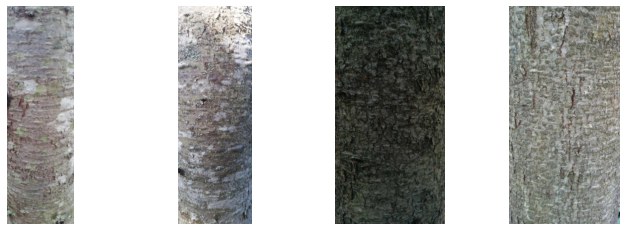

__________________________________________________________________________________________
ERR  Érable rouge 
/content/lab_id_arbres/train/ERR/551_ERR_71_GalaxyS7_20170922_124512_29.jpg
/content/lab_id_arbres/train/ERR/556_ERR_84_GalaxyS7_20170922_125622_6.jpg
/content/lab_id_arbres/train/ERR/543_ERR_25_GalaxyS7_20170922_122524_19.jpg
/content/lab_id_arbres/train/ERR/200_ERR_50_Nexus 5_20170804_111645_8.jpg


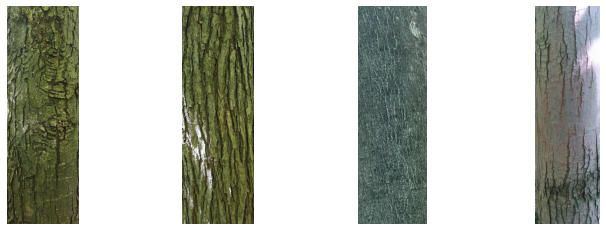

__________________________________________________________________________________________
ERS  Érable à sucre 
/content/lab_id_arbres/train/ERS/589_ERS_28_GalaxyS7_20170920_170726_2.jpg
/content/lab_id_arbres/train/ERS/591_ERS_46_GalaxyS7_20170920_171255_9.jpg
/content/lab_id_arbres/train/ERS/230_ERS_132_Nexus 5_20170804_094535_10.jpg
/content/lab_id_arbres/train/ERS/772_ERS_117_GalaxyS5_20170615_113648_6.jpg


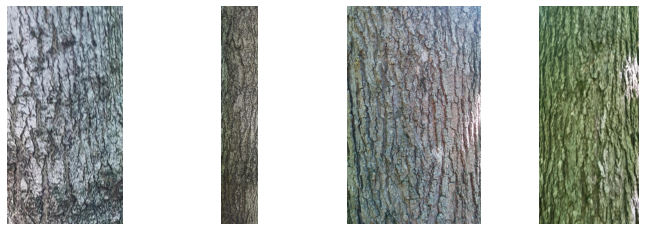

__________________________________________________________________________________________
BOJ  Bouleau jaune 
/content/lab_id_arbres/train/BOJ/24_BOJ_39_Nexus 5_20170615_125900_11.jpg
/content/lab_id_arbres/train/BOJ/640_BOJ_84_GalaxyS5_20170615_104556_25.jpg
/content/lab_id_arbres/train/BOJ/662_BOJ_98_GalaxyS5_20170712_105405_2.jpg
/content/lab_id_arbres/train/BOJ/26_BOJ_100_Nexus 5_20170804_091719_10.jpg


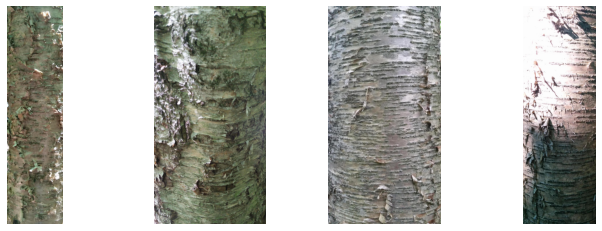

__________________________________________________________________________________________
BOP  Bouleau à papier 
/content/lab_id_arbres/train/BOP/3_BOP_111_Lumix_20170804_094059_6.jpg
/content/lab_id_arbres/train/BOP/664_BOP_61_GalaxyS5_20170615_114448_7.jpg
/content/lab_id_arbres/train/BOP/673_BOP_56_GalaxyS5_20170713_115954_3.jpg
/content/lab_id_arbres/train/BOP/472_BOP_48_GalaxyS5_20170607_154209_26.jpg


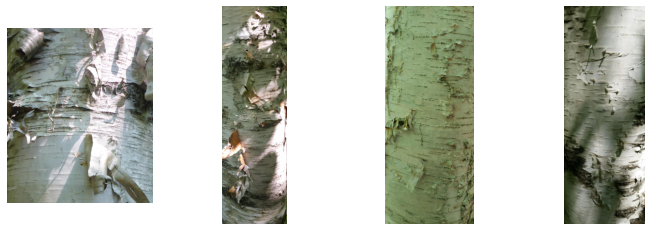

__________________________________________________________________________________________
HEG  Hêtre à grandes feuilles 
/content/lab_id_arbres/train/HEG/273_HEG_105_Nexus 5_20170607_160036_41.jpg
/content/lab_id_arbres/train/HEG/620_HEG_51_GalaxyS7_20170916_171438_13.jpg
/content/lab_id_arbres/train/HEG/625_HEG_50_GalaxyS7_20170916_180722_15.jpg
/content/lab_id_arbres/train/HEG/623_HEG_86_GalaxyS7_20170916_180146_11.jpg


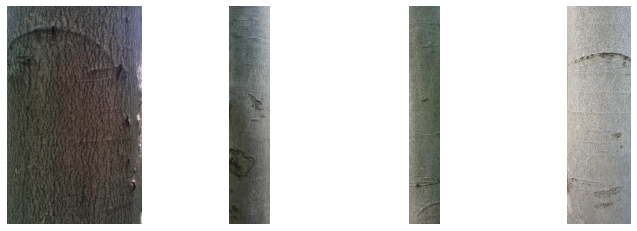

__________________________________________________________________________________________
FRA  Frêne d'Amérique 
/content/lab_id_arbres/train/FRA/250_FRA_144_Nexus 5_20170804_100422_7.jpg
/content/lab_id_arbres/train/FRA/268_FRA_74_Nexus 5_20170804_110241_6.jpg
/content/lab_id_arbres/train/FRA/602_FRA_59_GalaxyS5_20170607_144712_39.jpg
/content/lab_id_arbres/train/FRA/244_FRA_114_Nexus 5_20170804_095128_9.jpg


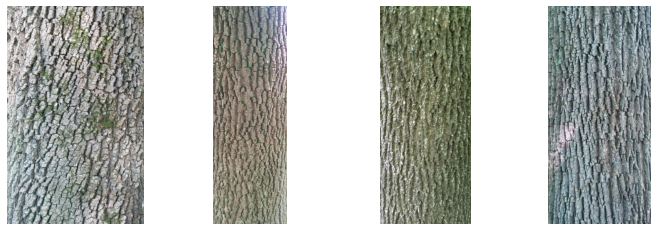

__________________________________________________________________________________________
MEL  Mélèze 
/content/lab_id_arbres/train/MEL/822_MEL_84_GalaxyS5_20170706_103817_16.jpg
/content/lab_id_arbres/train/MEL/828_MEL_99_GalaxyS5_20170706_104917_18.jpg
/content/lab_id_arbres/train/MEL/820_MEL_52_GalaxyS5_20170706_103542_10.jpg
/content/lab_id_arbres/train/MEL/841_MEL_76_GalaxyS5_20170706_111127_11.jpg


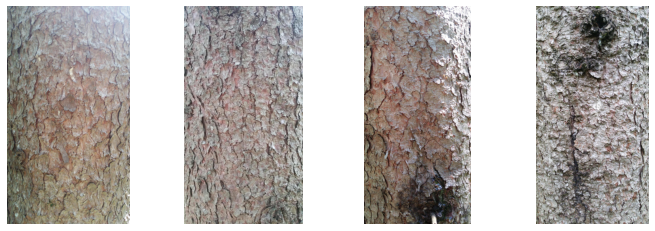

__________________________________________________________________________________________
OSV  Ostryer de Virginie 
/content/lab_id_arbres/train/OSV/896_OSV_49_GalaxyS5_20170713_115524_14.jpg
/content/lab_id_arbres/train/OSV/311_OSV_59_Nexus 5_20170906_105052_2.jpg
/content/lab_id_arbres/train/OSV/306_OSV_110_Nexus 5_20170810_122101_11.jpg
/content/lab_id_arbres/train/OSV/890_OSV_190_GalaxyS5_20170713_105525_5.jpg


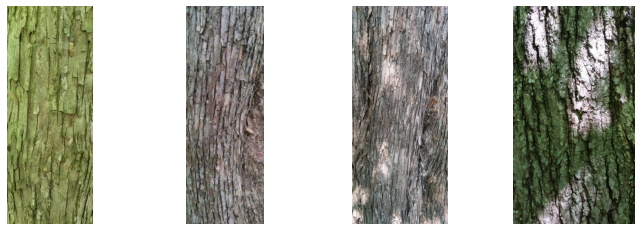

__________________________________________________________________________________________
EPO  Épinette de Norvège 
/content/lab_id_arbres/train/EPO/145_EPO_81_Nexus 5_20170921_154355_2.jpg
/content/lab_id_arbres/train/EPO/132_EPO_98_Nexus 5_20170921_152305_4.jpg
/content/lab_id_arbres/train/EPO/172_EPO_101_Nexus 5_20170922_103346_8.jpg
/content/lab_id_arbres/train/EPO/142_EPO_86_Nexus 5_20170921_154113_8.jpg


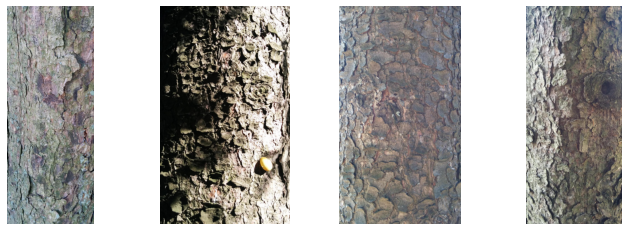

__________________________________________________________________________________________
EPB  Épinette blanche 
/content/lab_id_arbres/train/EPB/82_EPB_90_Nexus 5_20170817_105916_10.jpg
/content/lab_id_arbres/train/EPB/95_EPB_76_Nexus 5_20170817_111636_10.jpg
/content/lab_id_arbres/train/EPB/94_EPB_95_Nexus 5_20170817_111521_7.jpg
/content/lab_id_arbres/train/EPB/107_EPB_82_Nexus 5_20170817_113309_8.jpg


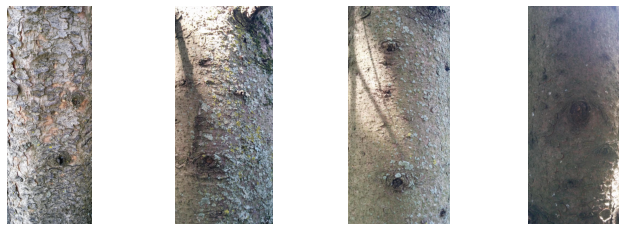

__________________________________________________________________________________________
EPN  Épinette noire 
/content/lab_id_arbres/train/EPN/727_EPN_90_GalaxyS5_20170622_112107_5.jpg
/content/lab_id_arbres/train/EPN/727_EPN_90_GalaxyS5_20170622_112107_4.jpg
/content/lab_id_arbres/train/EPN/720_EPN_81_GalaxyS5_20170622_110522_9.jpg
/content/lab_id_arbres/train/EPN/699_EPN_98_GalaxyS5_20170622_100838_25.jpg


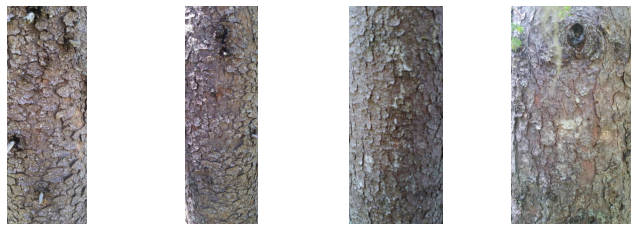

__________________________________________________________________________________________
EPR  Épinette rouge 
/content/lab_id_arbres/train/EPR/753_EPR_97_GalaxyS5_20170615_112415_10.jpg
/content/lab_id_arbres/train/EPR/536_EPR_42_GalaxyS7_20170607_143733_9.jpg
/content/lab_id_arbres/train/EPR/189_EPR_121_Nexus 5_20170615_135955_8.jpg
/content/lab_id_arbres/train/EPR/752_EPR_89_GalaxyS5_20170615_112241_20.jpg


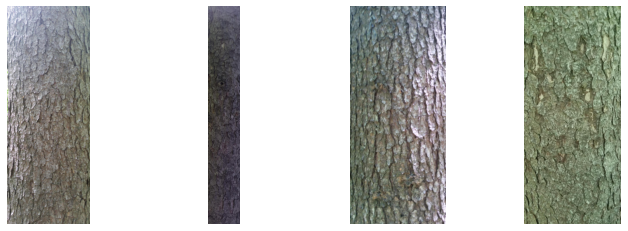

__________________________________________________________________________________________
PIR  Pin rouge 
/content/lab_id_arbres/train/PIR/355_PIR_120_Nexus 5_20170817_101049_4.jpg
/content/lab_id_arbres/train/PIR/349_PIR_112_Nexus 5_20170817_095640_14.jpg
/content/lab_id_arbres/train/PIR/354_PIR_119_Nexus 5_20170817_100942_5.jpg
/content/lab_id_arbres/train/PIR/367_PIR_95_Nexus 5_20170817_113920_11.jpg


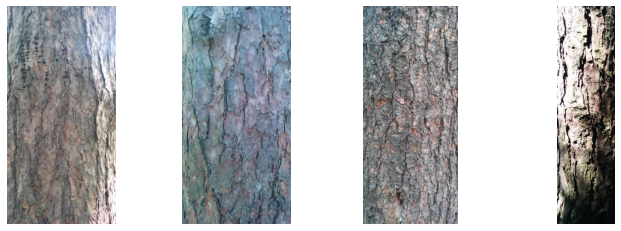

__________________________________________________________________________________________
PIB  Pin blanc 
/content/lab_id_arbres/train/PIB/335_PIB_59_Nexus 5_20170615_132024_8.jpg
/content/lab_id_arbres/train/PIB/338_PIB_100_Nexus 5_20170615_132928_21.jpg
/content/lab_id_arbres/train/PIB/319_PIB_90_Nexus 5_20170615_123306_33.jpg
/content/lab_id_arbres/train/PIB/339_PIB_99_GalaxyS5_20170615_133220_2.jpg


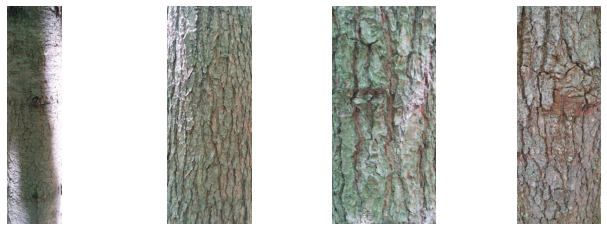

__________________________________________________________________________________________
PET  Peuplier faux tremble 
/content/lab_id_arbres/train/PET/921_PET_106_GalaxyS5_20170712_104504_5.jpg
/content/lab_id_arbres/train/PET/914_PET_113_GalaxyS5_20170712_103401_17.jpg
/content/lab_id_arbres/train/PET/925_PET_115_GalaxyS5_20170712_105529_13.jpg
/content/lab_id_arbres/train/PET/939_PET_63_GalaxyS5_20170712_112348_6.jpg


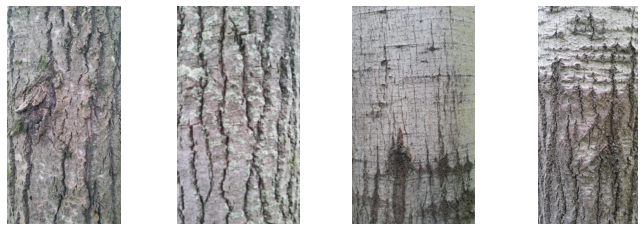

__________________________________________________________________________________________
CHR  Chêne rouge 
/content/lab_id_arbres/train/CHR/525_CHR_91_GalaxyS7_20170916_183552_8.jpg
/content/lab_id_arbres/train/CHR/478_CHR_132_GalaxyS7_20170916_142627_5.jpg
/content/lab_id_arbres/train/CHR/533_CHR_121_GalaxyS5_20170607_150317_3.jpg
/content/lab_id_arbres/train/CHR/505_CHR_48_GalaxyS7_20170916_162435_3.jpg


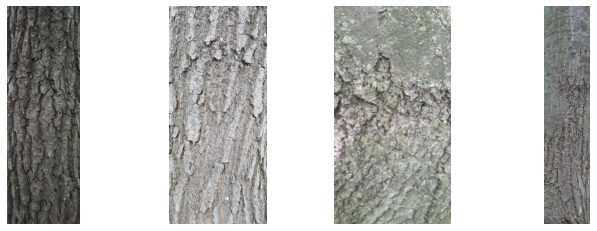

__________________________________________________________________________________________
THO  Thuya occidental 
/content/lab_id_arbres/train/THO/453_THO_90_Nexus 5_20170810_103824_3.jpg
/content/lab_id_arbres/train/THO/454_THO_60_Nexus 5_20170810_103929_3.jpg
/content/lab_id_arbres/train/THO/435_THO_109_Nexus 5_20170810_101318_12.jpg
/content/lab_id_arbres/train/THO/445_THO_80_Nexus 5_20170810_103134_9.jpg


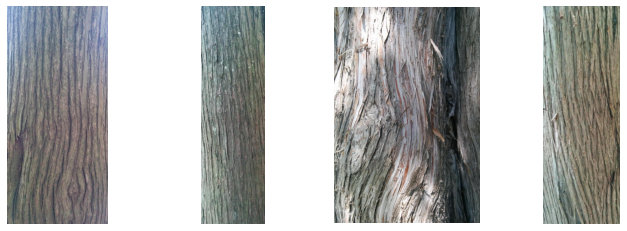

__________________________________________________________________________________________
PRU  Pruche du Canada 
/content/lab_id_arbres/train/PRU/399_PRU_76_Nexus 5_20170906_091929_21.jpg
/content/lab_id_arbres/train/PRU/976_PRU_121_GalaxyS5_20170713_110838_20.jpg
/content/lab_id_arbres/train/PRU/404_PRU_99_Nexus 5_20170906_092848_13.jpg
/content/lab_id_arbres/train/PRU/399_PRU_76_Nexus 5_20170906_091929_20.jpg


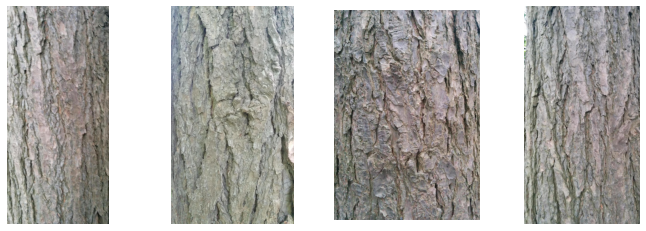

__________________________________________________________________________________________
ORA  Orme d'Amérique 
/content/lab_id_arbres/train/ORA/629_ORA_255_GalaxyS5_20170607_140656_9.jpg
/content/lab_id_arbres/train/ORA/291_ORA_69_Nexus 5_20170810_105335_6.jpg
/content/lab_id_arbres/train/ORA/885_ORA_106_GalaxyS5_20170712_103027_13.jpg
/content/lab_id_arbres/train/ORA/291_ORA_69_Nexus 5_20170810_105335_4.jpg


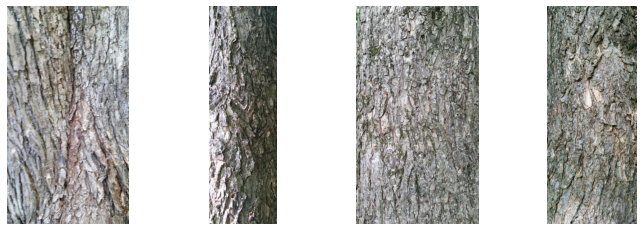

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 4

TRAINING_DIR = "/content/lab_id_arbres/train/"

for arbre_id in data_ecorces.keys():
    try:
        dir_path = os.path.join(TRAINING_DIR,arbre_id+os.sep)
        liste_fichiers = os.listdir(os.path.join(TRAINING_DIR,arbre_id+os.sep))
        next_two_pics = [os.path.join(dir_path, fname) for fname in liste_fichiers[0:pic_index]]
        fig = plt.figure(figsize=(12,4))
        print("_"*90)
        print(arbre_id,noms_arbres[data_ecorces[arbre_id]].split('-')[1])
        for i, img_path in enumerate(next_two_pics):
            print(img_path)
            img = mpimg.imread(img_path)
            plt.subplot(1,pic_index,i+1)
            plt.imshow(img)
            plt.axis('Off')
        plt.show()
    except:
        continue

### Création de flux de lots de données pour l'entraînement

Chargeons ces images en mémoire en créant des `tf.data.dataset` à l'aide de l'utilitaire `tf.keras.utils.image_dataset_from_directory`. 

tf.data.Dataset prend en charge l'écriture de chaîne de traitement d'entrée de données efficaces. L'itération se produit dans un flux continu, de sorte que l'ensemble de données complet n'a pas besoin de tenir dans la mémoire.

In [14]:
import os
import numpy as np
import keras
print("Keras version:",keras.__version__)
import tensorflow as tf
print("TensorFlow version:",tf.__version__)

Keras version: 2.7.0
TensorFlow version: 2.7.0


In [15]:
TRAINING_DIR = "/content/lab_id_arbres/train/"
VALIDATION_DIR = "/content/lab_id_arbres/val"
TESTING_DIR = "/content/lab_id_arbres/test/"

BATCH_SIZE = 32
IMG_SIZE = (150, 150)

train_dataset = tf.keras.utils.image_dataset_from_directory(TRAINING_DIR,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 3175 files belonging to 20 classes.


In [16]:
print("type(train_dataset):",type(train_dataset))
examples, labels = next(iter(train_dataset))
print("examples.shape:",examples.shape)
print("len(examples):",len(examples))
print("labels.shape:",labels.shape)

type(train_dataset): <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
examples.shape: (32, 150, 150, 3)
len(examples): 32
labels.shape: (32,)


In [17]:
id_classes = train_dataset.class_names
print(id_classes)
print(len(id_classes))

['BOJ', 'BOP', 'CHR', 'EPB', 'EPN', 'EPO', 'EPR', 'ERR', 'ERS', 'FRA', 'HEG', 'MEL', 'ORA', 'OSV', 'PET', 'PIB', 'PIR', 'PRU', 'SAB', 'THO']
20


In [18]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(VALIDATION_DIR,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 588 files belonging to 20 classes.


In [19]:
test_dataset = tf.keras.utils.image_dataset_from_directory(TESTING_DIR,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)
AUTOTUNE = tf.data.AUTOTUNE
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 218 files belonging to 20 classes.


In [20]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of training batches: 100
Number of validation batches: 19
Number of test batches: 7


## Prétraitement des données

### Normalisation des données

In [21]:
resize_and_rescale = keras.Sequential([
  keras.layers.Resizing(150,150),
  keras.layers.Rescaling(1./255)
])


### Amplification des données

In [51]:
data_augmentation = tf.keras.Sequential([
  keras.layers.RandomFlip("horizontal"),
  keras.layers.RandomFlip("vertical"),
  keras.layers.RandomRotation(0.1),
  keras.layers.RandomZoom(0.3),
  keras.layers.RandomContrast(0.3),
])

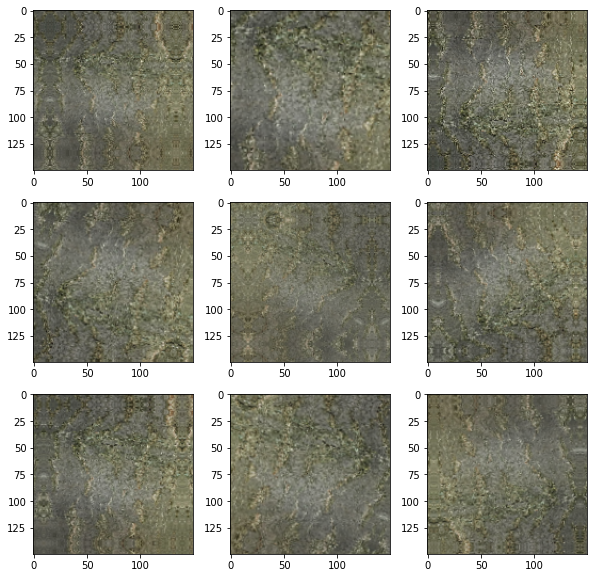

In [53]:
fig = plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  fig.clear()
  for i in range(9):
    augmented_images = data_augmentation(images)
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    # plt.imshow(augmented_images[0], cmap="gray")

In [54]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def pretraitement(ds, shuffle=False, augment=False):
  if shuffle:
    ds = ds.shuffle(1000)
    
  # Batch all datasets.
  # ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x,training=True), y),
                num_parallel_calls=AUTOTUNE
    )

  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
              num_parallel_calls=AUTOTUNE
  )

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

print("Fonction pretraitement prête!")

Fonction pretraitement prête!


In [55]:
print("type(train_dataset):",type(train_dataset))
normalized_train_dataset = pretraitement(train_dataset,
                                         shuffle=True,
                                         augment=True)
print("type(normalized_train_dataset):",type(normalized_train_dataset))
image_batch, labels_batch = next(iter(normalized_train_dataset))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

type(train_dataset): <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
type(normalized_train_dataset): <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
0.010275697 0.97469693


In [56]:
examples, labels = next(iter(normalized_train_dataset))
print("examples.shape:",examples.shape)
print("len(examples):",len(examples))
print("labels.shape:",labels.shape)

examples.shape: (32, 150, 150, 3)
len(examples): 32
labels.shape: (32,)


In [57]:
# normalized_validation_dataset = validation_dataset.map(lambda x, y: (resize_and_rescale(x), y))
print("type(validation_dataset):",type(validation_dataset))
normalized_validation_dataset = pretraitement(validation_dataset,
                                              shuffle=False,
                                              augment=False)
print("type(normalized_validation_dataset):",type(normalized_validation_dataset))
image_batch, labels_batch = next(iter(normalized_validation_dataset))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

type(validation_dataset): <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
type(normalized_validation_dataset): <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
0.00049007643 0.8002284


In [58]:
examples, labels = next(iter(normalized_validation_dataset))
print("examples.shape:",examples.shape)
print("len(examples):",len(examples))
print("labels.shape:",labels.shape)

examples.shape: (32, 150, 150, 3)
len(examples): 32
labels.shape: (32,)


In [59]:
print("type(test_dataset):",type(test_dataset))
normalized_test_dataset = test_dataset.map(lambda x, y: (resize_and_rescale(x), y))
# normalized_test_dataset = pretraitement(test_dataset,
#                                         shuffle=False,
#                                         augment=False)
print("type(normalized_test_dataset):",type(normalized_test_dataset))
image_batch, labels_batch = next(iter(normalized_test_dataset))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

type(test_dataset): <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
type(normalized_test_dataset): <class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
0.050483663 0.9915471


In [60]:
examples, labels = next(iter(normalized_test_dataset))
print("examples.shape:",examples.shape)
print("len(examples):",len(examples))
print("labels.shape:",labels.shape)

examples.shape: (32, 150, 150, 3)
len(examples): 32
labels.shape: (32,)


# Création d'un modèle d'apprentissage par transfert

## Importation d'un modèle inception pré-entraîné

In [61]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-02-03 19:23:40--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.183.128, 173.194.194.128, 142.250.152.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.183.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   172MB/s    in 0.5s    

2022-02-03 19:23:41 (172 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [62]:
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.applications.inception_v3 import InceptionV3

# Load weights pre-trained on ImageNet
pre_trained_model = InceptionV3(weights='imagenet',  
                                input_shape = (150, 150, 3), 
                                include_top = False)

# Create new data input
inputs = keras.Input(shape=(150, 150, 3))

# pre_trained_model.summary()

In [63]:
pre_trained_model.trainable = True

# Let's take a look to see how many layers are in the pretrained model
nbr_layers_pretrained_model = len(pre_trained_model.layers)
print("Nombre de couches dans le modèle pré-entraîné d'origine: ", nbr_layers_pretrained_model)

# How to get the layer index from the layer name
# https://www.thetopsites.net/article/50151157.shtml
layer_names = [layer.name for layer in pre_trained_model.layers]
last_layer_name = layer_names[-1]
print("Nom de la dernière couche du modèle pré-entraîné complet:",last_layer_name)
last_layer_index = layer_names.index(last_layer_name)
# Choix d'une nouvelle couche de sortie par essai / erreur
last_layer_name = 'mixed5'
# last_layer_name = 'mixed10'
print("Choix empirique de la dernière du modèle pré-entraîné:",last_layer_name)
last_layer_index = layer_names.index(last_layer_name)
print("Index de la dernière couche du modèle pré-entraîné:",last_layer_index)
# Choix de la dernière couche non-entraînable ou dernière couche « gelée »
last_layer_frozen_name = 'mixed3'
# last_layer_frozen_name = 'mixed10'
print("Choix empirique de la dernière couche non-entraînable:",last_layer_frozen_name)
last_layer_frozen_index = layer_names.index(last_layer_frozen_name)
print("Index de la dernière couche non-entraînable:",last_layer_frozen_index)
# Fine-tune from this layer onwards
fine_tune_at = last_layer_frozen_index
print("Nombre de couches non entraînables dans le modèle préentraîné: ", fine_tune_at )
# Freeze all the layers before the `fine_tune_at` layer
for layer in pre_trained_model.layers[:fine_tune_at]:
    layer.trainable =  False

print("Nombre de couches entraînables dans le modèle préentraîné: ", last_layer_index-fine_tune_at)
last_layer = pre_trained_model.get_layer(last_layer_name)
print('Dimensions de la dernière couche: ', last_layer.output_shape)
last_output = last_layer.output

Nombre de couches dans le modèle pré-entraîné d'origine:  311
Nom de la dernière couche du modèle pré-entraîné complet: mixed10
Choix empirique de la dernière du modèle pré-entraîné: mixed5
Index de la dernière couche du modèle pré-entraîné: 164
Choix empirique de la dernière couche non-entraînable: mixed3
Index de la dernière couche non-entraînable: 100
Nombre de couches non entraînables dans le modèle préentraîné:  100
Nombre de couches entraînables dans le modèle préentraîné:  64
Dimensions de la dernière couche:  (None, 7, 7, 768)


In [64]:
# Add a dropout rate of 0.1
outputs = layers.Dropout(0.1)(last_output)
# Flatten the output layer to 1 dimension
outputs = layers.Flatten()(outputs)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
outputs = layers.Dense(1024, activation='relu')(outputs)
# Add a dropout rate of 0.2
outputs = layers.Dropout(0.2)(outputs)      
# Add a final softmax layer for classification
# *** IMPORTANT *** 20 classes
number_of_target_class = 20
outputs = layers.Dense(number_of_target_class, activation='softmax')(outputs)           

transfer_model = Model(pre_trained_model.input, outputs) 
print("Number of layers in the learning transfer model: ", len(transfer_model.layers))


Number of layers in the learning transfer model:  170


In [65]:
# transfer_model.summary()


In [66]:
len(transfer_model.trainable_variables)


44

## Compilation du modèle

In [67]:
from tensorflow.keras.optimizers import RMSprop

# According to tf.keras.utils.image_dataset_from_directory documentation, 'int' is the default label_mode
# 'int': means that the labels are encoded as integers (e.g. for sparse_categorical_crossentropy loss)
# So, by default, tf.keras.utils.image_dataset_from_directory will create a set of labels for the dataset 
# as integer that go from 1 to the number of classes in the dataset.
# In this case, the model should be compiled with a 'sparse_categorical_crossentropy' loss.
transfer_model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

print("Modèle compilé!")

Modèle compilé!


## Entraînement du modèle

In [68]:
initial_epochs = 10
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

# Callbacks are passed to the model via the callbacks argument in fit, 
# which takes a list of callbacks. You can pass any number of callbacks.
callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath="id_arbres_CNN_transfert_amplification.keras",
                      save_best_only=True,
                      monitor="val_loss"),
                  # Interrupts training when improvement stops
                  keras.callbacks.EarlyStopping(
                      # Monitors the model’s validation accuracy
                      monitor='val_accuracy',
                      # Interrupts training when accuracy has stopped 
                      # improving for more than 3 epoch (that is, 4 epochs)
                      patience=10,
                      verbose=2),
                  keras.callbacks.ReduceLROnPlateau(
                      # Monitors the model’s validation loss
                      monitor='val_loss',
                      # Divides the learning rate by 2 when triggered
                      factor=0.5,
                      # The callback is triggered after the validation loss
                      # has stopped improving for 1 epoch.
                      patience=3,
                      verbose=2) 
]
history_fine = transfer_model.fit(normalized_train_dataset,
                                  validation_data = normalized_validation_dataset,
                                  epochs = total_epochs,
                                  callbacks=callbacks_list,
                                  verbose = 2)


Epoch 1/40
100/100 - 43s - loss: 2.2552 - accuracy: 0.3606 - val_loss: 1.3263 - val_accuracy: 0.5867 - lr: 1.0000e-04 - 43s/epoch - 425ms/step
Epoch 2/40
100/100 - 39s - loss: 1.2923 - accuracy: 0.5849 - val_loss: 1.0592 - val_accuracy: 0.6820 - lr: 1.0000e-04 - 39s/epoch - 391ms/step
Epoch 3/40
100/100 - 39s - loss: 1.0058 - accuracy: 0.6706 - val_loss: 1.0359 - val_accuracy: 0.6684 - lr: 1.0000e-04 - 39s/epoch - 386ms/step
Epoch 4/40
100/100 - 38s - loss: 0.8960 - accuracy: 0.7074 - val_loss: 0.8251 - val_accuracy: 0.7534 - lr: 1.0000e-04 - 38s/epoch - 383ms/step
Epoch 5/40
100/100 - 38s - loss: 0.7543 - accuracy: 0.7512 - val_loss: 0.7513 - val_accuracy: 0.7721 - lr: 1.0000e-04 - 38s/epoch - 384ms/step
Epoch 6/40
100/100 - 37s - loss: 0.6866 - accuracy: 0.7704 - val_loss: 0.8646 - val_accuracy: 0.7551 - lr: 1.0000e-04 - 37s/epoch - 374ms/step
Epoch 7/40
100/100 - 37s - loss: 0.6139 - accuracy: 0.7937 - val_loss: 0.8861 - val_accuracy: 0.7551 - lr: 1.0000e-04 - 37s/epoch - 374ms/step

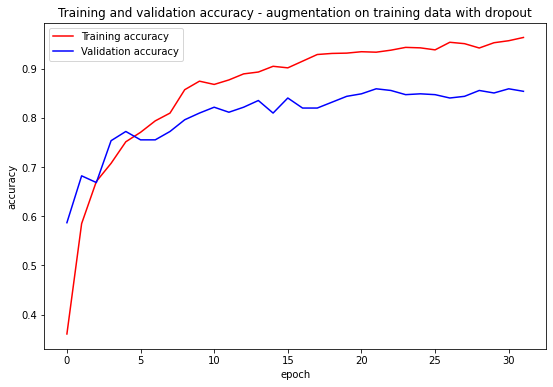

In [69]:
# dernière couche 'mixed5', dernière couche gelée 'mixed3'
# 40 époques max + amplification
# Test accuracy : 80 à 84%
import matplotlib.pyplot as plt
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']
epochs = range(len(acc))
golden_number = 1.618
height = 6
length = int(golden_number * height)
plt.figure(figsize=(length,height))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy - augmentation on training data with dropout')
plt.legend(loc=0)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()


In [70]:
# dernière couche 'mixed10', dernière couche gelée 'mixed10'
# 20 epochs
# Test accuracy : 0.5871559381484985

In [71]:
erreur, exactitude = transfer_model.evaluate(normalized_test_dataset)
print("Exactitude données de test accuracy:   %0.2f" % exactitude)

7/7 [==============================] - 0s 20ms/step - loss: 0.6838 - accuracy: 0.8532
Exactitude données de test accuracy:   0.85


In [72]:
print("type(test_dataset):",type(test_dataset))
print("type(normalized_test_dataset):",type(normalized_test_dataset))
image_batch, labels_batch = next(iter(normalized_test_dataset))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

type(test_dataset): <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
type(normalized_test_dataset): <class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
0.050483663 0.9915471


In [73]:
examples, labels = next(iter(normalized_test_dataset))
print("examples.shape:",examples.shape)
print("len(examples):",len(examples))
print("labels.shape:",labels.shape)

examples.shape: (32, 150, 150, 3)
len(examples): 32
labels.shape: (32,)


In [74]:
predictions = transfer_model.predict(normalized_test_dataset)
predictions_index = np.argmax(predictions, axis=1)
predictions_index = [(etiquette+1) for etiquette in predictions_index]
print(predictions_index)

[9, 3, 12, 15, 5, 9, 4, 3, 12, 17, 12, 8, 15, 9, 1, 15, 6, 3, 16, 9, 6, 3, 6, 10, 4, 19, 3, 3, 8, 12, 16, 10, 3, 12, 14, 6, 13, 12, 9, 12, 8, 13, 14, 16, 2, 19, 6, 6, 3, 9, 17, 12, 15, 8, 16, 20, 8, 4, 6, 6, 13, 4, 16, 15, 5, 3, 3, 9, 19, 14, 17, 6, 3, 6, 15, 10, 6, 13, 3, 16, 4, 19, 8, 2, 9, 12, 4, 5, 15, 1, 7, 9, 14, 16, 18, 16, 15, 9, 18, 19, 12, 9, 3, 19, 2, 15, 6, 5, 8, 12, 16, 12, 3, 9, 2, 5, 3, 15, 10, 5, 17, 3, 16, 3, 5, 9, 18, 2, 17, 7, 19, 3, 20, 2, 7, 6, 1, 4, 12, 9, 20, 11, 6, 6, 20, 2, 20, 14, 8, 8, 20, 10, 1, 3, 19, 4, 15, 12, 14, 10, 20, 1, 15, 9, 20, 5, 16, 3, 16, 18, 9, 12, 3, 1, 20, 10, 9, 11, 10, 3, 9, 19, 10, 18, 2, 5, 18, 3, 11, 3, 9, 10, 12, 15, 3, 8, 3, 4, 5, 3, 1, 2, 8, 16, 19, 3, 8, 12, 11, 11, 17, 4, 7, 7, 1, 10, 6, 19]


In [75]:
vraies_etiquettes_index = list(np.concatenate([etiquette for image, etiquette in normalized_test_dataset], axis=0))
vraies_etiquettes_index = [(etiquette+1) for etiquette in vraies_etiquettes_index]
print(vraies_etiquettes_index)

[9, 9, 12, 15, 5, 9, 4, 3, 12, 17, 12, 8, 15, 9, 1, 15, 1, 3, 16, 8, 6, 3, 6, 10, 4, 19, 3, 3, 8, 12, 16, 10, 3, 12, 14, 6, 14, 12, 9, 12, 8, 13, 14, 16, 2, 19, 6, 6, 11, 8, 17, 12, 15, 8, 7, 20, 8, 4, 6, 6, 13, 4, 16, 15, 5, 18, 3, 9, 19, 14, 17, 17, 3, 6, 15, 10, 6, 13, 3, 16, 4, 19, 8, 2, 9, 12, 6, 5, 3, 1, 18, 9, 14, 16, 18, 13, 15, 9, 18, 19, 12, 9, 15, 19, 1, 15, 6, 5, 8, 12, 16, 12, 3, 9, 13, 5, 3, 15, 10, 5, 17, 3, 3, 3, 5, 10, 18, 2, 17, 7, 19, 3, 20, 2, 7, 6, 1, 4, 7, 8, 20, 11, 6, 6, 20, 2, 20, 14, 9, 11, 20, 10, 1, 18, 11, 4, 8, 12, 14, 10, 20, 1, 15, 10, 20, 5, 9, 3, 16, 18, 8, 12, 3, 1, 20, 10, 9, 11, 10, 3, 9, 4, 10, 18, 2, 5, 18, 3, 11, 15, 9, 10, 12, 15, 3, 11, 3, 4, 5, 9, 1, 2, 8, 16, 19, 3, 8, 12, 11, 11, 17, 4, 7, 7, 1, 10, 6, 19]


In [76]:
from sklearn import metrics
score = metrics.accuracy_score(vraies_etiquettes_index, predictions_index)
print("Exactitude:   %0.2f" % score)

Exactitude:   0.85


Text(0.5, 1.0, 'Matrice de confusion')

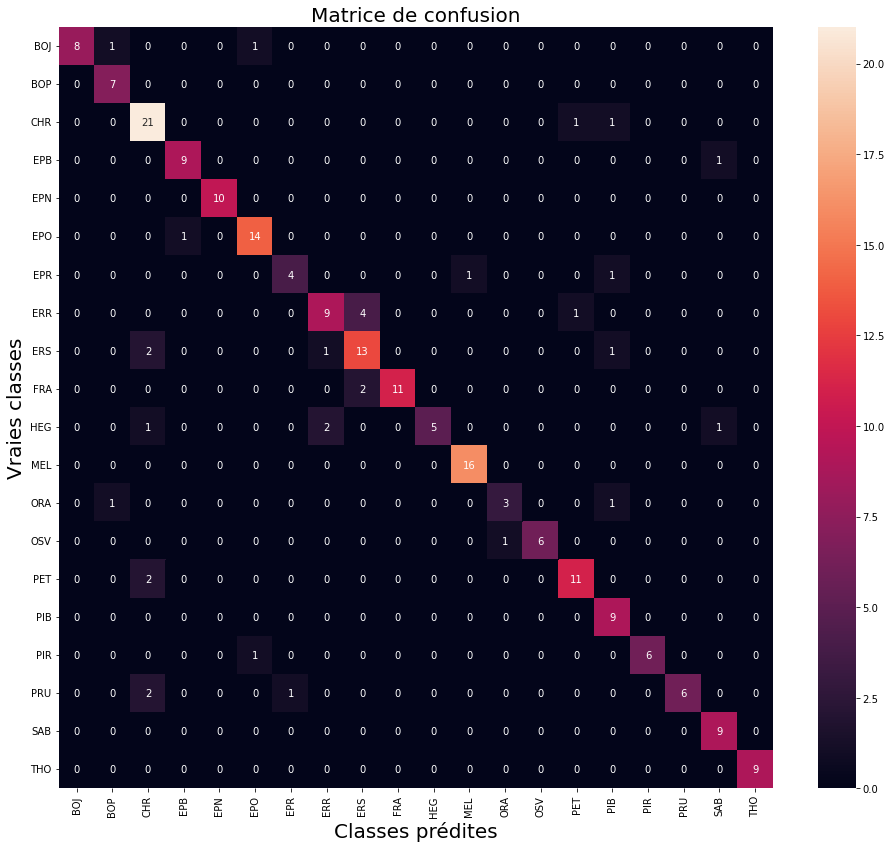

In [77]:
# https://stackoverflow.com/questions/65618137/confusion-matrix-for-multiple-classes-in-python
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix

y_true=np.argmax(vraies_etiquettes_index, axis=-1)
y_true= vraies_etiquettes_index
y_pred = predictions_index
cm = confusion_matrix(y_true, y_pred)

## Get Class Labels
class_names = list(id_classes)

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Classes prédites', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('Vraies classes', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Matrice de confusion', fontsize=20)


Matrice de confusion non normalisée


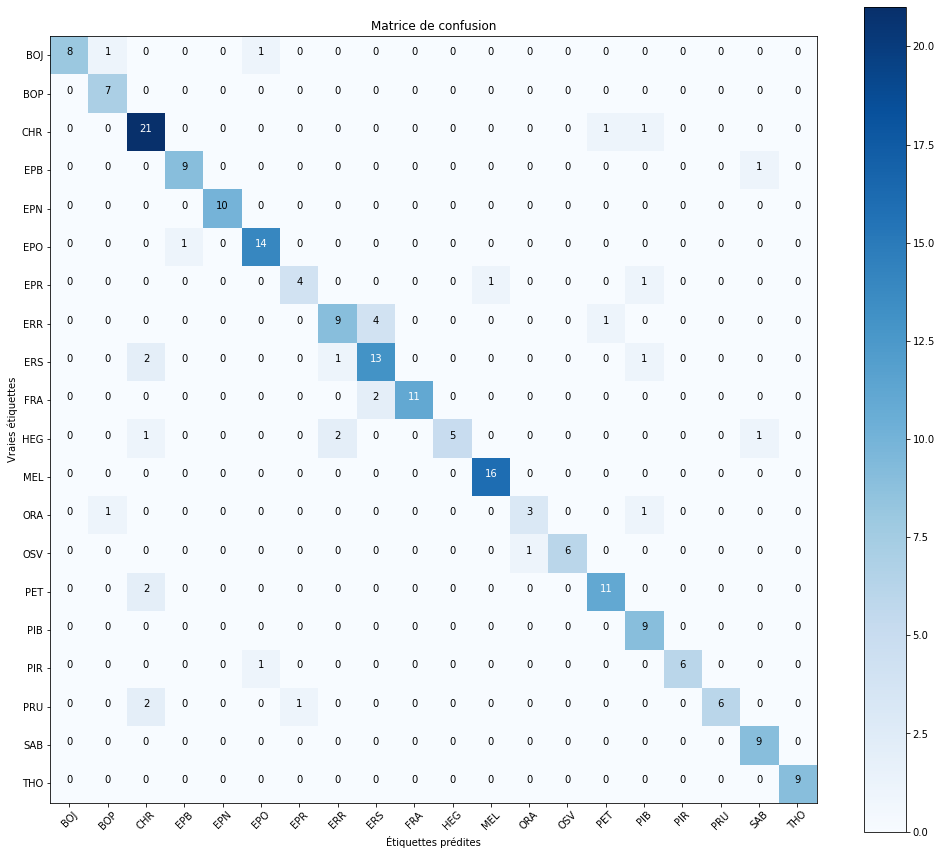

In [78]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matrice de confusion',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(14,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matrice de confusion normalisée")
    else:
        print('Matrice de confusion non normalisée')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Vraies étiquettes')
    plt.xlabel('Étiquettes prédites')

cm = metrics.confusion_matrix(vraies_etiquettes_index, predictions_index)
plot_confusion_matrix(cm, classes=class_names)

## Résultats

Les résultats dans une fourchette de 82 à 85% ne sont pas excellents. Avec 32 Go de données l'équipe de chercheurs de l'Université Laval à Québec avait obtenu 93%. Mais avec 1.5 Go de données (21 fois moins de données), on ne peut pas faire de miracle... 


In [79]:
print("Fin de l'exécution du carnet IPython")

Fin de l'exécution du carnet IPython
